## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np
import pdb

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've defined the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=56180, out_features=500, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=500, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = None
data_transform = transforms.Compose([Rescale(255),
                                    RandomCrop(224),
                                    Normalize(),
                                    ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [5]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [6]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above


# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [7]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
       
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

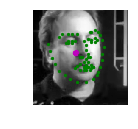

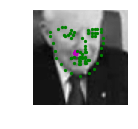

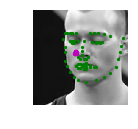

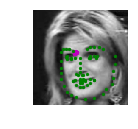

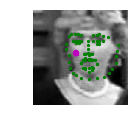

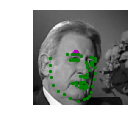

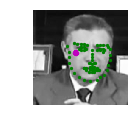

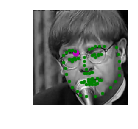

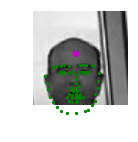

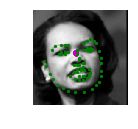

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](https://pytorch.org/docs/master/nn.html#loss-functions).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [12]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = torch.nn.MSELoss()

optimizer = optim.Adam(net.parameters())


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [13]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [14]:
# train your network
n_epochs = 100 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.006530152887105942
Epoch: 1, Batch: 20, Avg. Loss: 0.005321978121995926
Epoch: 1, Batch: 30, Avg. Loss: 0.004409537941217422
Epoch: 1, Batch: 40, Avg. Loss: 0.0031441439539194108
Epoch: 1, Batch: 50, Avg. Loss: 0.0022686224430799483
Epoch: 1, Batch: 60, Avg. Loss: 0.0027559279948472975
Epoch: 1, Batch: 70, Avg. Loss: 0.0023502977192401886
Epoch: 1, Batch: 80, Avg. Loss: 0.0023552894294261934
Epoch: 1, Batch: 90, Avg. Loss: 0.0021216098144650457
Epoch: 1, Batch: 100, Avg. Loss: 0.0026851988583803175
Epoch: 1, Batch: 110, Avg. Loss: 0.0020420041158795356
Epoch: 1, Batch: 120, Avg. Loss: 0.002546909585595131
Epoch: 1, Batch: 130, Avg. Loss: 0.0025014574751257897
Epoch: 1, Batch: 140, Avg. Loss: 0.002251052498817444
Epoch: 1, Batch: 150, Avg. Loss: 0.003041230022907257
Epoch: 1, Batch: 160, Avg. Loss: 0.002191776029765606
Epoch: 1, Batch: 170, Avg. Loss: 0.002355489283800125
Epoch: 1, Batch: 180, Avg. Loss: 0.002549401208758354
Epoch: 1, Batch: 190, Avg. L

Epoch: 5, Batch: 160, Avg. Loss: 0.0021534036993980407
Epoch: 5, Batch: 170, Avg. Loss: 0.0013222532495856284
Epoch: 5, Batch: 180, Avg. Loss: 0.0015138634517788887
Epoch: 5, Batch: 190, Avg. Loss: 0.0014887742027640343
Epoch: 5, Batch: 200, Avg. Loss: 0.001507087357342243
Epoch: 5, Batch: 210, Avg. Loss: 0.0009087066352367401
Epoch: 5, Batch: 220, Avg. Loss: 0.001342857699841261
Epoch: 5, Batch: 230, Avg. Loss: 0.0011373562887310982
Epoch: 5, Batch: 240, Avg. Loss: 0.0028280888721346855
Epoch: 5, Batch: 250, Avg. Loss: 0.0013703431710600854
Epoch: 5, Batch: 260, Avg. Loss: 0.0012156640961766244
Epoch: 5, Batch: 270, Avg. Loss: 0.0017940864115953445
Epoch: 5, Batch: 280, Avg. Loss: 0.0010413141399621963
Epoch: 5, Batch: 290, Avg. Loss: 0.0012287905514240265
Epoch: 5, Batch: 300, Avg. Loss: 0.001971690371632576
Epoch: 5, Batch: 310, Avg. Loss: 0.00216591926664114
Epoch: 5, Batch: 320, Avg. Loss: 0.0011597605347633362
Epoch: 5, Batch: 330, Avg. Loss: 0.0010865594781935214
Epoch: 5, Batch

Epoch: 9, Batch: 310, Avg. Loss: 0.000814812570810318
Epoch: 9, Batch: 320, Avg. Loss: 0.000817554721608758
Epoch: 9, Batch: 330, Avg. Loss: 0.0010082626789808273
Epoch: 9, Batch: 340, Avg. Loss: 0.0011356849782168865
Epoch: 10, Batch: 10, Avg. Loss: 0.0012181775979697705
Epoch: 10, Batch: 20, Avg. Loss: 0.0007830702997744084
Epoch: 10, Batch: 30, Avg. Loss: 0.001093121387064457
Epoch: 10, Batch: 40, Avg. Loss: 0.0007385798282921314
Epoch: 10, Batch: 50, Avg. Loss: 0.0008721099868416786
Epoch: 10, Batch: 60, Avg. Loss: 0.0007779328413307667
Epoch: 10, Batch: 70, Avg. Loss: 0.0008896775618195534
Epoch: 10, Batch: 80, Avg. Loss: 0.0009163081683218479
Epoch: 10, Batch: 90, Avg. Loss: 0.0008508214354515076
Epoch: 10, Batch: 100, Avg. Loss: 0.0009078223742544651
Epoch: 10, Batch: 110, Avg. Loss: 0.0006288684196770191
Epoch: 10, Batch: 120, Avg. Loss: 0.0010603490993380546
Epoch: 10, Batch: 130, Avg. Loss: 0.0007452507875859737
Epoch: 10, Batch: 140, Avg. Loss: 0.001187122143805027
Epoch: 10

Epoch: 14, Batch: 90, Avg. Loss: 0.0005775754489004612
Epoch: 14, Batch: 100, Avg. Loss: 0.0006428614109754562
Epoch: 14, Batch: 110, Avg. Loss: 0.0006637210752815008
Epoch: 14, Batch: 120, Avg. Loss: 0.0008639177940785884
Epoch: 14, Batch: 130, Avg. Loss: 0.0011920080836862325
Epoch: 14, Batch: 140, Avg. Loss: 0.0008139007072895765
Epoch: 14, Batch: 150, Avg. Loss: 0.0007581851892173291
Epoch: 14, Batch: 160, Avg. Loss: 0.0005294540282338858
Epoch: 14, Batch: 170, Avg. Loss: 0.0006122257634997368
Epoch: 14, Batch: 180, Avg. Loss: 0.0016114235445857047
Epoch: 14, Batch: 190, Avg. Loss: 0.0006222281418740749
Epoch: 14, Batch: 200, Avg. Loss: 0.0006497848741710186
Epoch: 14, Batch: 210, Avg. Loss: 0.000833026010543108
Epoch: 14, Batch: 220, Avg. Loss: 0.0006273120231926441
Epoch: 14, Batch: 230, Avg. Loss: 0.000915497463196516
Epoch: 14, Batch: 240, Avg. Loss: 0.0005916998069733381
Epoch: 14, Batch: 250, Avg. Loss: 0.0008441784717142582
Epoch: 14, Batch: 260, Avg. Loss: 0.000767234407365

Epoch: 18, Batch: 210, Avg. Loss: 0.000988618068397045
Epoch: 18, Batch: 220, Avg. Loss: 0.0004689045026898384
Epoch: 18, Batch: 230, Avg. Loss: 0.0015761737376451493
Epoch: 18, Batch: 240, Avg. Loss: 0.0009548308625817299
Epoch: 18, Batch: 250, Avg. Loss: 0.0008498699888586998
Epoch: 18, Batch: 260, Avg. Loss: 0.0005944943651556969
Epoch: 18, Batch: 270, Avg. Loss: 0.0006383159160614014
Epoch: 18, Batch: 280, Avg. Loss: 0.0005338649544864893
Epoch: 18, Batch: 290, Avg. Loss: 0.0007648292835801839
Epoch: 18, Batch: 300, Avg. Loss: 0.0008777252770960331
Epoch: 18, Batch: 310, Avg. Loss: 0.0006757471449673175
Epoch: 18, Batch: 320, Avg. Loss: 0.0006788888201117515
Epoch: 18, Batch: 330, Avg. Loss: 0.0005839656107127667
Epoch: 18, Batch: 340, Avg. Loss: 0.000995837550610304
Epoch: 19, Batch: 10, Avg. Loss: 0.0007767244167625904
Epoch: 19, Batch: 20, Avg. Loss: 0.0004899723865091801
Epoch: 19, Batch: 30, Avg. Loss: 0.0005911993570625782
Epoch: 19, Batch: 40, Avg. Loss: 0.000595208954066038

Epoch: 22, Batch: 330, Avg. Loss: 0.0007309475913643837
Epoch: 22, Batch: 340, Avg. Loss: 0.0005609575882554054
Epoch: 23, Batch: 10, Avg. Loss: 0.0007042888328433037
Epoch: 23, Batch: 20, Avg. Loss: 0.0005689194314181805
Epoch: 23, Batch: 30, Avg. Loss: 0.0006958985608071089
Epoch: 23, Batch: 40, Avg. Loss: 0.00047551685571670533
Epoch: 23, Batch: 50, Avg. Loss: 0.0005228331405669451
Epoch: 23, Batch: 60, Avg. Loss: 0.0006424872875213623
Epoch: 23, Batch: 70, Avg. Loss: 0.0007604274749755859
Epoch: 23, Batch: 80, Avg. Loss: 0.0007853507362306118
Epoch: 23, Batch: 90, Avg. Loss: 0.0010079074651002883
Epoch: 23, Batch: 100, Avg. Loss: 0.0005726366713643074
Epoch: 23, Batch: 110, Avg. Loss: 0.001002148412168026
Epoch: 23, Batch: 120, Avg. Loss: 0.0004322880543768406
Epoch: 23, Batch: 130, Avg. Loss: 0.000703952357172966
Epoch: 23, Batch: 140, Avg. Loss: 0.00048044340498745443
Epoch: 23, Batch: 150, Avg. Loss: 0.0005162880904972554
Epoch: 23, Batch: 160, Avg. Loss: 0.0008679891377687454
E

Epoch: 27, Batch: 110, Avg. Loss: 0.0006721185892820358
Epoch: 27, Batch: 120, Avg. Loss: 0.0006694756597280502
Epoch: 27, Batch: 130, Avg. Loss: 0.0005423279404640198
Epoch: 27, Batch: 140, Avg. Loss: 0.0004294798169285059
Epoch: 27, Batch: 150, Avg. Loss: 0.0006732176505029201
Epoch: 27, Batch: 160, Avg. Loss: 0.0006154319755733013
Epoch: 27, Batch: 170, Avg. Loss: 0.0005082867164164782
Epoch: 27, Batch: 180, Avg. Loss: 0.0005564794614911079
Epoch: 27, Batch: 190, Avg. Loss: 0.0004979676064103841
Epoch: 27, Batch: 200, Avg. Loss: 0.0005505040697753429
Epoch: 27, Batch: 210, Avg. Loss: 0.0007617357820272445
Epoch: 27, Batch: 220, Avg. Loss: 0.0007807970680296421
Epoch: 27, Batch: 230, Avg. Loss: 0.0006096075996756553
Epoch: 27, Batch: 240, Avg. Loss: 0.0004011620096862316
Epoch: 27, Batch: 250, Avg. Loss: 0.0006717839948832989
Epoch: 27, Batch: 260, Avg. Loss: 0.0005729047320783138
Epoch: 27, Batch: 270, Avg. Loss: 0.0004377546180039644
Epoch: 27, Batch: 280, Avg. Loss: 0.000859624743

Epoch: 31, Batch: 220, Avg. Loss: 0.0006039043124765157
Epoch: 31, Batch: 230, Avg. Loss: 0.0005027549285441637
Epoch: 31, Batch: 240, Avg. Loss: 0.0007822033241391182
Epoch: 31, Batch: 250, Avg. Loss: 0.0005627303197979927
Epoch: 31, Batch: 260, Avg. Loss: 0.0008654489442706108
Epoch: 31, Batch: 270, Avg. Loss: 0.0006892921589314937
Epoch: 31, Batch: 280, Avg. Loss: 0.0005701383408159017
Epoch: 31, Batch: 290, Avg. Loss: 0.0005427440889179707
Epoch: 31, Batch: 300, Avg. Loss: 0.0004803543295711279
Epoch: 31, Batch: 310, Avg. Loss: 0.0005118364505469799
Epoch: 31, Batch: 320, Avg. Loss: 0.000540527019649744
Epoch: 31, Batch: 330, Avg. Loss: 0.00043395755626261237
Epoch: 31, Batch: 340, Avg. Loss: 0.0005845528729259968
Epoch: 32, Batch: 10, Avg. Loss: 0.0007458178456872702
Epoch: 32, Batch: 20, Avg. Loss: 0.000660180252045393
Epoch: 32, Batch: 30, Avg. Loss: 0.0006338257603347302
Epoch: 32, Batch: 40, Avg. Loss: 0.0005755760874599219
Epoch: 32, Batch: 50, Avg. Loss: 0.000902012031525373

Epoch: 35, Batch: 340, Avg. Loss: 0.0006604614108800888
Epoch: 36, Batch: 10, Avg. Loss: 0.0005385911092162133
Epoch: 36, Batch: 20, Avg. Loss: 0.0005321075282990933
Epoch: 36, Batch: 30, Avg. Loss: 0.0005742107778787613
Epoch: 36, Batch: 40, Avg. Loss: 0.0005297714211046695
Epoch: 36, Batch: 50, Avg. Loss: 0.0003971805665642023
Epoch: 36, Batch: 60, Avg. Loss: 0.0006672846414148807
Epoch: 36, Batch: 70, Avg. Loss: 0.000515710286796093
Epoch: 36, Batch: 80, Avg. Loss: 0.0005499286241829395
Epoch: 36, Batch: 90, Avg. Loss: 0.0005508926399052143
Epoch: 36, Batch: 100, Avg. Loss: 0.0006952519491314888
Epoch: 36, Batch: 110, Avg. Loss: 0.0006765257120132447
Epoch: 36, Batch: 120, Avg. Loss: 0.0004579711556434631
Epoch: 36, Batch: 130, Avg. Loss: 0.0023492360785603524
Epoch: 36, Batch: 140, Avg. Loss: 0.00048325747810304165
Epoch: 36, Batch: 150, Avg. Loss: 0.0005098027922213077
Epoch: 36, Batch: 160, Avg. Loss: 0.0005757524706423283
Epoch: 36, Batch: 170, Avg. Loss: 0.000602726873010397
Ep

Epoch: 40, Batch: 120, Avg. Loss: 0.0004913576189428568
Epoch: 40, Batch: 130, Avg. Loss: 0.0004900371115654706
Epoch: 40, Batch: 140, Avg. Loss: 0.0005500591211020947
Epoch: 40, Batch: 150, Avg. Loss: 0.00042334749549627305
Epoch: 40, Batch: 160, Avg. Loss: 0.0006056882012635469
Epoch: 40, Batch: 170, Avg. Loss: 0.00042421409115195275
Epoch: 40, Batch: 180, Avg. Loss: 0.0005006414595991373
Epoch: 40, Batch: 190, Avg. Loss: 0.000722143355756998
Epoch: 40, Batch: 200, Avg. Loss: 0.0025825269687920808
Epoch: 40, Batch: 210, Avg. Loss: 0.0005599291510879993
Epoch: 40, Batch: 220, Avg. Loss: 0.0007323959041386842
Epoch: 40, Batch: 230, Avg. Loss: 0.0005007251668721437
Epoch: 40, Batch: 240, Avg. Loss: 0.0008785512149333954
Epoch: 40, Batch: 250, Avg. Loss: 0.0004807961657643318
Epoch: 40, Batch: 260, Avg. Loss: 0.00048093700781464576
Epoch: 40, Batch: 270, Avg. Loss: 0.0006810238733887672
Epoch: 40, Batch: 280, Avg. Loss: 0.001000019358471036
Epoch: 40, Batch: 290, Avg. Loss: 0.00057199030

Epoch: 44, Batch: 230, Avg. Loss: 0.00042707907781004906
Epoch: 44, Batch: 240, Avg. Loss: 0.0006658656857907772
Epoch: 44, Batch: 250, Avg. Loss: 0.0004395972527563572
Epoch: 44, Batch: 260, Avg. Loss: 0.000432948874309659
Epoch: 44, Batch: 270, Avg. Loss: 0.0007078849896788597
Epoch: 44, Batch: 280, Avg. Loss: 0.00043504842184484004
Epoch: 44, Batch: 290, Avg. Loss: 0.0005404975395649672
Epoch: 44, Batch: 300, Avg. Loss: 0.0004511319696903229
Epoch: 44, Batch: 310, Avg. Loss: 0.0006837826706469059
Epoch: 44, Batch: 320, Avg. Loss: 0.0008321683369576931
Epoch: 44, Batch: 330, Avg. Loss: 0.0004076000731438398
Epoch: 44, Batch: 340, Avg. Loss: 0.0004449620209634304
Epoch: 45, Batch: 10, Avg. Loss: 0.00041161534935235975
Epoch: 45, Batch: 20, Avg. Loss: 0.0004162221923470497
Epoch: 45, Batch: 30, Avg. Loss: 0.0004045779351145029
Epoch: 45, Batch: 40, Avg. Loss: 0.0008191635832190513
Epoch: 45, Batch: 50, Avg. Loss: 0.0005332333445549011
Epoch: 45, Batch: 60, Avg. Loss: 0.0005227257255464

Epoch: 49, Batch: 10, Avg. Loss: 0.00040723457746207715
Epoch: 49, Batch: 20, Avg. Loss: 0.0005809483639895916
Epoch: 49, Batch: 30, Avg. Loss: 0.0005474607795476913
Epoch: 49, Batch: 40, Avg. Loss: 0.00046517940238118173
Epoch: 49, Batch: 50, Avg. Loss: 0.0017175045255571604
Epoch: 49, Batch: 60, Avg. Loss: 0.0006844161432236433
Epoch: 49, Batch: 70, Avg. Loss: 0.0004027248155325651
Epoch: 49, Batch: 80, Avg. Loss: 0.0004948231056332588
Epoch: 49, Batch: 90, Avg. Loss: 0.0006026088558137417
Epoch: 49, Batch: 100, Avg. Loss: 0.0012794537283480167
Epoch: 49, Batch: 110, Avg. Loss: 0.0004518457558006048
Epoch: 49, Batch: 120, Avg. Loss: 0.0005580621026456356
Epoch: 49, Batch: 130, Avg. Loss: 0.0006104359179735184
Epoch: 49, Batch: 140, Avg. Loss: 0.0006005633734166622
Epoch: 49, Batch: 150, Avg. Loss: 0.0005169172752648592
Epoch: 49, Batch: 160, Avg. Loss: 0.0004379844833165407
Epoch: 49, Batch: 170, Avg. Loss: 0.0004376526363193989
Epoch: 49, Batch: 180, Avg. Loss: 0.0004477286599576473

Epoch: 53, Batch: 120, Avg. Loss: 0.0007063923180103302
Epoch: 53, Batch: 130, Avg. Loss: 0.000603739459067583
Epoch: 53, Batch: 140, Avg. Loss: 0.0006833596713840961
Epoch: 53, Batch: 150, Avg. Loss: 0.0006677667032927274
Epoch: 53, Batch: 160, Avg. Loss: 0.0006161911729723216
Epoch: 53, Batch: 170, Avg. Loss: 0.0005192105639725924
Epoch: 53, Batch: 180, Avg. Loss: 0.0004848994631320238
Epoch: 53, Batch: 190, Avg. Loss: 0.0006464399881660938
Epoch: 53, Batch: 200, Avg. Loss: 0.0005529464483261108
Epoch: 53, Batch: 210, Avg. Loss: 0.0005537639614194631
Epoch: 53, Batch: 220, Avg. Loss: 0.0005011569894850254
Epoch: 53, Batch: 230, Avg. Loss: 0.0013026791717857123
Epoch: 53, Batch: 240, Avg. Loss: 0.00046802125312387944
Epoch: 53, Batch: 250, Avg. Loss: 0.0004356145691126585
Epoch: 53, Batch: 260, Avg. Loss: 0.0004447565209120512
Epoch: 53, Batch: 270, Avg. Loss: 0.00042839346453547476
Epoch: 53, Batch: 280, Avg. Loss: 0.00030834333412349226
Epoch: 53, Batch: 290, Avg. Loss: 0.0004381690

Epoch: 57, Batch: 230, Avg. Loss: 0.0004936327375471592
Epoch: 57, Batch: 240, Avg. Loss: 0.0006541229672729969
Epoch: 57, Batch: 250, Avg. Loss: 0.00041743642464280126
Epoch: 57, Batch: 260, Avg. Loss: 0.0007541976012289524
Epoch: 57, Batch: 270, Avg. Loss: 0.0004839413519948721
Epoch: 57, Batch: 280, Avg. Loss: 0.0003893156386911869
Epoch: 57, Batch: 290, Avg. Loss: 0.0004375976920127869
Epoch: 57, Batch: 300, Avg. Loss: 0.0003889458402991295
Epoch: 57, Batch: 310, Avg. Loss: 0.00039192144200205805
Epoch: 57, Batch: 320, Avg. Loss: 0.0005337826386094093
Epoch: 57, Batch: 330, Avg. Loss: 0.0005070151574909687
Epoch: 57, Batch: 340, Avg. Loss: 0.00045907405391335486
Epoch: 58, Batch: 10, Avg. Loss: 0.0006705946289002895
Epoch: 58, Batch: 20, Avg. Loss: 0.0005411686617881059
Epoch: 58, Batch: 30, Avg. Loss: 0.0003920920882374048
Epoch: 58, Batch: 40, Avg. Loss: 0.00047145684249699115
Epoch: 58, Batch: 50, Avg. Loss: 0.000560767637565732
Epoch: 58, Batch: 60, Avg. Loss: 0.000495145697146

Epoch: 61, Batch: 340, Avg. Loss: 0.0003759086262434721
Epoch: 62, Batch: 10, Avg. Loss: 0.0005718459021300077
Epoch: 62, Batch: 20, Avg. Loss: 0.0008601424731314182
Epoch: 62, Batch: 30, Avg. Loss: 0.0009518769439309836
Epoch: 62, Batch: 40, Avg. Loss: 0.0004885085225105286
Epoch: 62, Batch: 50, Avg. Loss: 0.0003991456013172865
Epoch: 62, Batch: 60, Avg. Loss: 0.000527789182960987
Epoch: 62, Batch: 70, Avg. Loss: 0.0006788879837840796
Epoch: 62, Batch: 80, Avg. Loss: 0.0004360242933034897
Epoch: 62, Batch: 90, Avg. Loss: 0.0004515311103314161
Epoch: 62, Batch: 100, Avg. Loss: 0.0005063285902142525
Epoch: 62, Batch: 110, Avg. Loss: 0.0006790663804858923
Epoch: 62, Batch: 120, Avg. Loss: 0.0005029456336051226
Epoch: 62, Batch: 130, Avg. Loss: 0.0004993630442768336
Epoch: 62, Batch: 140, Avg. Loss: 0.0004252421278506517
Epoch: 62, Batch: 150, Avg. Loss: 0.00042422273382544516
Epoch: 62, Batch: 160, Avg. Loss: 0.0005895433109253645
Epoch: 62, Batch: 170, Avg. Loss: 0.0004632889777421951
E

Epoch: 66, Batch: 110, Avg. Loss: 0.0007091871649026871
Epoch: 66, Batch: 120, Avg. Loss: 0.0007597537189722062
Epoch: 66, Batch: 130, Avg. Loss: 0.0007161700427532196
Epoch: 66, Batch: 140, Avg. Loss: 0.0007109715677797795
Epoch: 66, Batch: 150, Avg. Loss: 0.00048320719227194786
Epoch: 66, Batch: 160, Avg. Loss: 0.0006292495168745518
Epoch: 66, Batch: 170, Avg. Loss: 0.0009226631075143814
Epoch: 66, Batch: 180, Avg. Loss: 0.0006007735505700111
Epoch: 66, Batch: 190, Avg. Loss: 0.0005502202697098255
Epoch: 66, Batch: 200, Avg. Loss: 0.0006215193010866642
Epoch: 66, Batch: 210, Avg. Loss: 0.0005275884829461574
Epoch: 66, Batch: 220, Avg. Loss: 0.000566232543438673
Epoch: 66, Batch: 230, Avg. Loss: 0.0004859670698642731
Epoch: 66, Batch: 240, Avg. Loss: 0.0005722557902336121
Epoch: 66, Batch: 250, Avg. Loss: 0.0005563000366091729
Epoch: 66, Batch: 260, Avg. Loss: 0.0009730119854211807
Epoch: 66, Batch: 270, Avg. Loss: 0.000529967861250043
Epoch: 66, Batch: 280, Avg. Loss: 0.0004653278440

Epoch: 70, Batch: 220, Avg. Loss: 0.0007152579184621572
Epoch: 70, Batch: 230, Avg. Loss: 0.00041833782941102984
Epoch: 70, Batch: 240, Avg. Loss: 0.0005270569194108247
Epoch: 70, Batch: 250, Avg. Loss: 0.0005062659978866577
Epoch: 70, Batch: 260, Avg. Loss: 0.00047663759253919124
Epoch: 70, Batch: 270, Avg. Loss: 0.00044888365268707276
Epoch: 70, Batch: 280, Avg. Loss: 0.0005209997743368149
Epoch: 70, Batch: 290, Avg. Loss: 0.0019035638961941003
Epoch: 70, Batch: 300, Avg. Loss: 0.0006578695476055145
Epoch: 70, Batch: 310, Avg. Loss: 0.0010025271996855737
Epoch: 70, Batch: 320, Avg. Loss: 0.0006110378727316857
Epoch: 70, Batch: 330, Avg. Loss: 0.0005545502975583076
Epoch: 70, Batch: 340, Avg. Loss: 0.0008192857578396797
Epoch: 71, Batch: 10, Avg. Loss: 0.00044159478694200517
Epoch: 71, Batch: 20, Avg. Loss: 0.0004690764602273703
Epoch: 71, Batch: 30, Avg. Loss: 0.0005688795652240515
Epoch: 71, Batch: 40, Avg. Loss: 0.0005296184383332729
Epoch: 71, Batch: 50, Avg. Loss: 0.0004310685899

Epoch: 74, Batch: 330, Avg. Loss: 0.00036138733476400375
Epoch: 74, Batch: 340, Avg. Loss: 0.00046492259576916696
Epoch: 75, Batch: 10, Avg. Loss: 0.0007045736201107502
Epoch: 75, Batch: 20, Avg. Loss: 0.0005457428861409426
Epoch: 75, Batch: 30, Avg. Loss: 0.0005845012366771698
Epoch: 75, Batch: 40, Avg. Loss: 0.00044190235435962675
Epoch: 75, Batch: 50, Avg. Loss: 0.0005046832710504532
Epoch: 75, Batch: 60, Avg. Loss: 0.0004474494103342295
Epoch: 75, Batch: 70, Avg. Loss: 0.0003773466646671295
Epoch: 75, Batch: 80, Avg. Loss: 0.0003126563113182783
Epoch: 75, Batch: 90, Avg. Loss: 0.0004208190180361271
Epoch: 75, Batch: 100, Avg. Loss: 0.00046431684866547583
Epoch: 75, Batch: 110, Avg. Loss: 0.00037901298701763155
Epoch: 75, Batch: 120, Avg. Loss: 0.00047635046392679217
Epoch: 75, Batch: 130, Avg. Loss: 0.000548627644777298
Epoch: 75, Batch: 140, Avg. Loss: 0.0004302352666854858
Epoch: 75, Batch: 150, Avg. Loss: 0.0006732183732092381
Epoch: 75, Batch: 160, Avg. Loss: 0.0004012566432356

Epoch: 79, Batch: 100, Avg. Loss: 0.0005232001710683107
Epoch: 79, Batch: 110, Avg. Loss: 0.0012800422981381417
Epoch: 79, Batch: 120, Avg. Loss: 0.0006951294057071208
Epoch: 79, Batch: 130, Avg. Loss: 0.0008055379875004291
Epoch: 79, Batch: 140, Avg. Loss: 0.0005418058689683676
Epoch: 79, Batch: 150, Avg. Loss: 0.0004674181342124939
Epoch: 79, Batch: 160, Avg. Loss: 0.0004278620146214962
Epoch: 79, Batch: 170, Avg. Loss: 0.0006020766235888004
Epoch: 79, Batch: 180, Avg. Loss: 0.0005685361158102751
Epoch: 79, Batch: 190, Avg. Loss: 0.0005408959165215492
Epoch: 79, Batch: 200, Avg. Loss: 0.0006431951597332954
Epoch: 79, Batch: 210, Avg. Loss: 0.00048711184039711955
Epoch: 79, Batch: 220, Avg. Loss: 0.000753346424549818
Epoch: 79, Batch: 230, Avg. Loss: 0.0003806334435939789
Epoch: 79, Batch: 240, Avg. Loss: 0.0006054438613355159
Epoch: 79, Batch: 250, Avg. Loss: 0.0005526867285370827
Epoch: 79, Batch: 260, Avg. Loss: 0.00043759580701589583
Epoch: 79, Batch: 270, Avg. Loss: 0.00046718231

Epoch: 83, Batch: 210, Avg. Loss: 0.0005206263363361359
Epoch: 83, Batch: 220, Avg. Loss: 0.0008153223432600498
Epoch: 83, Batch: 230, Avg. Loss: 0.000531835950911045
Epoch: 83, Batch: 240, Avg. Loss: 0.0006065161935985088
Epoch: 83, Batch: 250, Avg. Loss: 0.00048335122875869273
Epoch: 83, Batch: 260, Avg. Loss: 0.0005362811628729105
Epoch: 83, Batch: 270, Avg. Loss: 0.0004941253662109375
Epoch: 83, Batch: 280, Avg. Loss: 0.00039727946743369104
Epoch: 83, Batch: 290, Avg. Loss: 0.0004694325067102909
Epoch: 83, Batch: 300, Avg. Loss: 0.000884834734722972
Epoch: 83, Batch: 310, Avg. Loss: 0.0006789998188614845
Epoch: 83, Batch: 320, Avg. Loss: 0.00045998965576291083
Epoch: 83, Batch: 330, Avg. Loss: 0.0008739559259265661
Epoch: 83, Batch: 340, Avg. Loss: 0.0006204290892928839
Epoch: 84, Batch: 10, Avg. Loss: 0.0004646867597475648
Epoch: 84, Batch: 20, Avg. Loss: 0.00048278309032320977
Epoch: 84, Batch: 30, Avg. Loss: 0.0005442740879952907
Epoch: 84, Batch: 40, Avg. Loss: 0.00047533377446

Epoch: 87, Batch: 320, Avg. Loss: 0.0006246716268360615
Epoch: 87, Batch: 330, Avg. Loss: 0.0005174334775656462
Epoch: 87, Batch: 340, Avg. Loss: 0.0011059773731976748
Epoch: 88, Batch: 10, Avg. Loss: 0.0017142510414123536
Epoch: 88, Batch: 20, Avg. Loss: 0.0005900204926729203
Epoch: 88, Batch: 30, Avg. Loss: 0.0004723670333623886
Epoch: 88, Batch: 40, Avg. Loss: 0.00038630575127899646
Epoch: 88, Batch: 50, Avg. Loss: 0.000560483606532216
Epoch: 88, Batch: 60, Avg. Loss: 0.0003860220108181238
Epoch: 88, Batch: 70, Avg. Loss: 0.0003772278539836407
Epoch: 88, Batch: 80, Avg. Loss: 0.0005232090316712857
Epoch: 88, Batch: 90, Avg. Loss: 0.0009129979107528925
Epoch: 88, Batch: 100, Avg. Loss: 0.0005232194997370243
Epoch: 88, Batch: 110, Avg. Loss: 0.0005249409582465887
Epoch: 88, Batch: 120, Avg. Loss: 0.0005272327810525894
Epoch: 88, Batch: 130, Avg. Loss: 0.0005022779982537031
Epoch: 88, Batch: 140, Avg. Loss: 0.0004165693297982216
Epoch: 88, Batch: 150, Avg. Loss: 0.0004180649798363447
E

Epoch: 92, Batch: 90, Avg. Loss: 0.0007179861366748809
Epoch: 92, Batch: 100, Avg. Loss: 0.00046925762481987476
Epoch: 92, Batch: 110, Avg. Loss: 0.0005910980068147182
Epoch: 92, Batch: 120, Avg. Loss: 0.0005632825754582882
Epoch: 92, Batch: 130, Avg. Loss: 0.000554730486124754
Epoch: 92, Batch: 140, Avg. Loss: 0.0004368553310632706
Epoch: 92, Batch: 150, Avg. Loss: 0.000333825858309865
Epoch: 92, Batch: 160, Avg. Loss: 0.000528909470885992
Epoch: 92, Batch: 170, Avg. Loss: 0.0005408194549381733
Epoch: 92, Batch: 180, Avg. Loss: 0.0004604898877441883
Epoch: 92, Batch: 190, Avg. Loss: 0.0007414289712905884
Epoch: 92, Batch: 200, Avg. Loss: 0.0003771026488393545
Epoch: 92, Batch: 210, Avg. Loss: 0.0005349617209285497
Epoch: 92, Batch: 220, Avg. Loss: 0.000842900313436985
Epoch: 92, Batch: 230, Avg. Loss: 0.0004245344828814268
Epoch: 92, Batch: 240, Avg. Loss: 0.000556965135037899
Epoch: 92, Batch: 250, Avg. Loss: 0.0004647780507802963
Epoch: 92, Batch: 260, Avg. Loss: 0.00040499982051551

Epoch: 96, Batch: 200, Avg. Loss: 0.0003597591482102871
Epoch: 96, Batch: 210, Avg. Loss: 0.000397941991686821
Epoch: 96, Batch: 220, Avg. Loss: 0.00052147158049047
Epoch: 96, Batch: 230, Avg. Loss: 0.0004327612426131964
Epoch: 96, Batch: 240, Avg. Loss: 0.0004106117617338896
Epoch: 96, Batch: 250, Avg. Loss: 0.0004053250066936016
Epoch: 96, Batch: 260, Avg. Loss: 0.0004300130251795053
Epoch: 96, Batch: 270, Avg. Loss: 0.00039279098808765414
Epoch: 96, Batch: 280, Avg. Loss: 0.0005165721531957388
Epoch: 96, Batch: 290, Avg. Loss: 0.000389719994738698
Epoch: 96, Batch: 300, Avg. Loss: 0.0003988880459219217
Epoch: 96, Batch: 310, Avg. Loss: 0.0005278429388999939
Epoch: 96, Batch: 320, Avg. Loss: 0.0004717503245919943
Epoch: 96, Batch: 330, Avg. Loss: 0.0005125626306980848
Epoch: 96, Batch: 340, Avg. Loss: 0.00038120981864631174
Epoch: 97, Batch: 10, Avg. Loss: 0.0005562998745590449
Epoch: 97, Batch: 20, Avg. Loss: 0.0004466248340904713
Epoch: 97, Batch: 30, Avg. Loss: 0.00041283208318054

Epoch: 100, Batch: 310, Avg. Loss: 0.0009110449682921171
Epoch: 100, Batch: 320, Avg. Loss: 0.0007824703138321638
Epoch: 100, Batch: 330, Avg. Loss: 0.00042329299636185167
Epoch: 100, Batch: 340, Avg. Loss: 0.0005886251777410507
Finished Training


## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [20]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


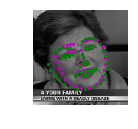

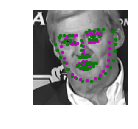

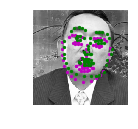

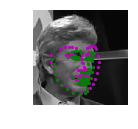

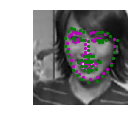

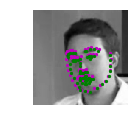

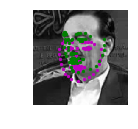

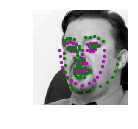

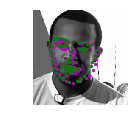

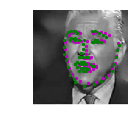

In [16]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [21]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: The optimizer used is Adam optimizer, and the loss function used is Mean Square Error. Adam optimizer is a well known optimizer which is computationally efficient and has little memory requirements, as compared to other optimizers. The keypoint detection is a regression problem, therefore, the MSE loss was used for training. 


### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I started with 2 convolutional layers, with 2 fully connected layers, and 1 dropout. And the model seems to perform pretty good with this model, so I didn't decide to modify the network. TO avoid the overfitting, I used the dropout in the architecture.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: The number of epochs was decided by observing the loss value, and the loss seems to have converged after 50 epochs. The batch size was determined by the number memory size of my local machine, where I trained the model.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.01588894 -0.12542146 -0.15709819 -0.0511399   0.23929814]
 [-0.29734448 -0.22952037  0.20803101  0.09410226  0.03440637]
 [-0.2863162  -0.19668202 -0.07640401 -0.02464511  0.21725354]
 [ 0.05048414 -0.16066852 -0.06523026  0.20364815  0.2789343 ]
 [-0.09965658  0.14074163  0.02632692 -0.06355696  0.30436942]]
(5, 5)


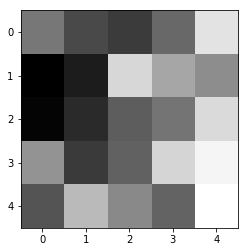

In [22]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in its convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

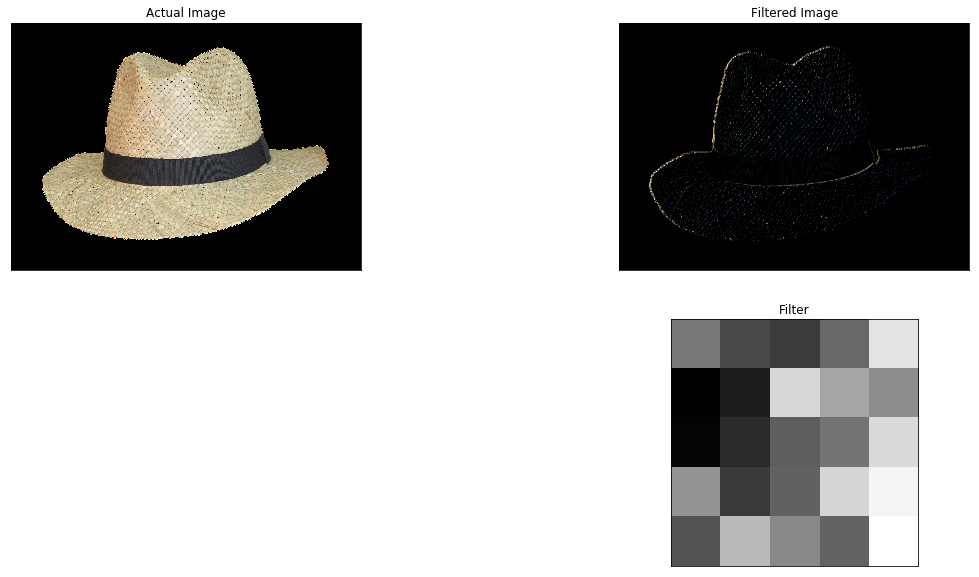

In [23]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

import cv2
img = cv2.imread('images/straw_hat.png')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(221, xticks=[], yticks=[])
ax.imshow(img)
ax.set_title("Actual Image")


ax = fig.add_subplot(224, xticks=[], yticks=[])
ax.imshow(w[filter_index][0], cmap='gray')
ax.set_title("Filter")

filtered = cv2.filter2D(img, -1, w[filter_index][0])

ax = fig.add_subplot(222, xticks=[], yticks=[])
ax.imshow(filtered)
ax.set_title("Filtered Image")
plt.show()



### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: The filtered image shows edges. Therefore, this filter detects edges in the image.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!